In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [3]:
def get_spectra(epoch, order, return_header=False):
    spectra = sorted(glob.glob(spectra_dir + '*.fits'))
    spectrum = spectra[epoch]
    wav, flux, flux_err = [], [], []
    spectra_data = pf.getdata( spectrum ) # Get the data
    spectra_hdr = pf.getheader( spectrum ) # Get the full header
    if return_header:
        return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:], spectra_hdr
    return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:]

In [4]:
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def interpolate_spectrum(x, y, int_wav=None, oversample=5):
    f1  = interpolate.interp1d(x, y, kind = 'cubic')
    df = x[1] - x[0]
    if int_wav is None:
        int_wav = np.arange(x[0], x[-1], df / oversample)
    int_flux = f1(int_wav)
    return int_wav, int_flux

def smooth_spectrum(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten_spectrum(x, y, k=3, s=10):
    spl = UnivariateSpline(x, y, k=k, s=s)
    return y / spl(x)

def resolve_spectrum(x, y):
    # Interpolate
    wav, flux = interpolate_spectrum(x,y)
    # Smooth
    flux = smooth_spectrum(wav, flux)
    # Flatten
    flux = flatten_spectrum(wav, flux)
    
    return wav, flux

In [5]:
order = 22
epochs = len(glob.glob(spectra_dir + '*.fits'))
obs_times = []
for epoch in range(epochs):
    wav, flux, hdr = get_spectra(epoch,order, return_header=True)
    obs_times.append(hdr['BJD-MID'] + 2400000)

In [6]:
porb = 51.4167

In [7]:
phase_secondary = [0.48, 0.492]
phase_primary = [0.73, 0.745]
phase_times = np.array(obs_times) % porb / porb

In [8]:
m_secondary = (phase_times < phase_secondary[1]) & (phase_times > phase_secondary[0])
m_primary = (phase_times < phase_primary[1]) & (phase_times > phase_primary[0])
m_outofeclipse = (~m_primary) & (~m_secondary)

In [44]:
m_primary

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [9]:
primary_spectra = np.arange(0, len(m_primary))[m_primary][:-1]
secondary_spectra = np.arange(0, len(m_secondary))[m_secondary]
outofeclipse_spectra = np.arange(0, len(m_secondary))[m_outofeclipse]

In [10]:
wav_shifts = np.array([4923.82244023, 4924.18844416, 4923.22957301, 4923.03460223,
       4923.05998058, 4923.0592043 , 4923.07143993, 4923.06979033,
       4923.12882913, 4923.22316656, 4923.28929584, 4923.3237547 ,
       4923.37387493, 4923.40832789, 4923.4635005 , 4923.51180739,
       4923.89321068, 4924.00170686, 4924.09076071, 4923.5310799 ,
       4923.45352609, 4923.37908476, 4923.13610577, 4923.12944722,
       4923.11823078, 4923.10666461, 4923.12013959, 4923.10809648,
       4923.12143378, 4923.19189685, 4923.24358028, 4923.27769998,
       4923.30074225, 4923.33051194, 4923.37062293, 4923.41016737,
       4923.45481685, 4923.49838237, 4923.72337275, 4923.79545627,
       4923.87909964, 4923.99176657, 4924.08913162, 4924.17289083,
       4924.28667265, 4924.41688023, 4924.5513964 , 4924.76794426,
       4924.79519154, 4924.76236818, 4924.62524671, 4924.45206184,
       4924.08899382, 4924.07722381, 4924.07933389, 4924.07705968,
       4924.07281623, 4924.06855177, 4924.04988574, 4924.0448962 ,
       4924.04706606])

wav_shifts = np.array([-0.0915913 ,  0.26033683, -0.70038709, -0.89535692, -0.86997843,
       -0.87075478, -0.85851908, -0.85506095, -0.80112998, -0.70679285,
       -0.64066379, -0.60620508, -0.55608518, -0.5216322 , -0.47436319,
       -0.41779333, -0.03116966,  0.07333483,  0.18058427, -0.38657061,
       -0.47358921, -0.5508825 , -0.79386422, -0.80052327, -0.81174071,
       -0.82330738, -0.81752276, -0.82187655, -0.80853981, -0.73807956,
       -0.68639732, -0.65227823, -0.62923657, -0.59946752, -0.56398004,
       -0.51981331, -0.475165  , -0.43736705, -0.20198662, -0.14237736,
       -0.05088621,  0.06847369,  0.17048313,  0.25504151,  0.37591421,
        0.50627662,  0.64576925,  0.84853629,  0.89659549,  0.84427746,
        0.71600074,  0.5307709 ,  0.16787024,  0.1628877 ,  0.15926703,
        0.1508248 ,  0.15159962,  0.14430931,  0.12417134,  0.12228407,
        0.086027  ])

# wav_shifts = -1*wav_shifts

In [11]:
import spectres

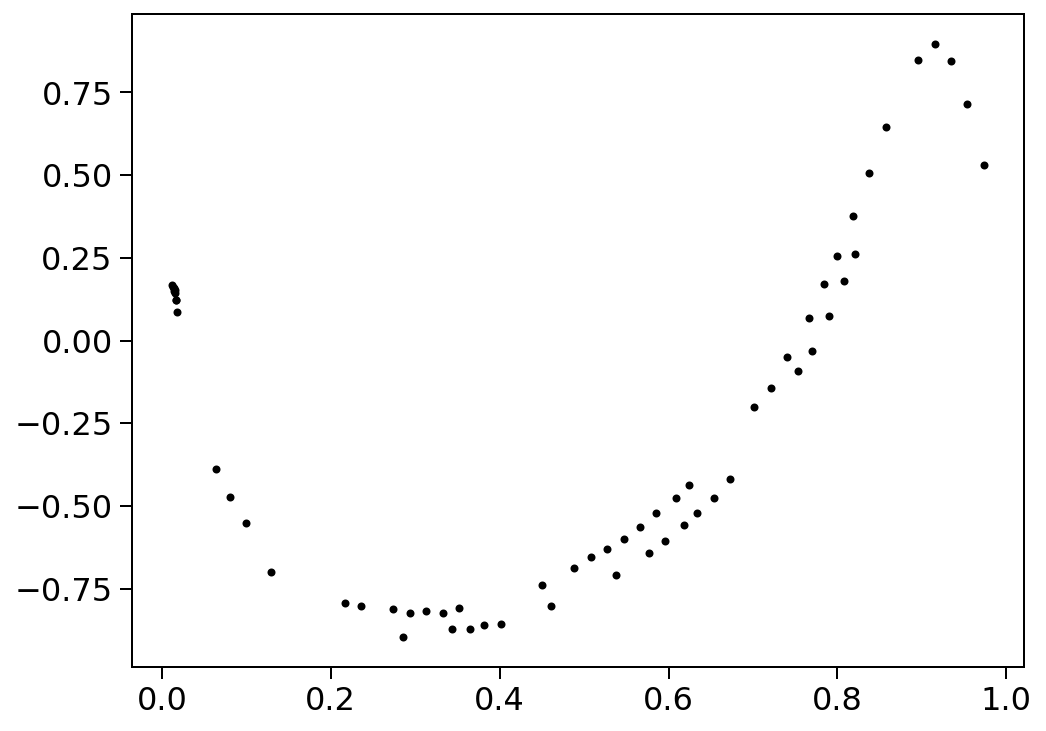

In [12]:
fold = (np.array(obs_times) % porb / porb)
sort = np.argsort(fold)
plt.plot(fold[sort],wav_shifts[sort],'.k')
# plt.plot(fold[sort],-wav_shifts[sort],'.k')


Spectres: new_wavs contains values outside the range in spec_wavs. New_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (nan by default).


Spectres: new_wavs contains values outside the range in spec_wavs. New_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (nan by default).


Spectres: new_wavs contains values outside the range in spec_wavs. New_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (nan by default).


Spectres: new_wavs contains values outside the range in spec_wavs. New_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (nan by default).


Spectres: new_wavs contains values outside the range in spec_wavs. New_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (nan by default).


Spectres: new_wavs contains values outside the range in spec_wavs. New_fluxes and new_errs will be filled with the valu

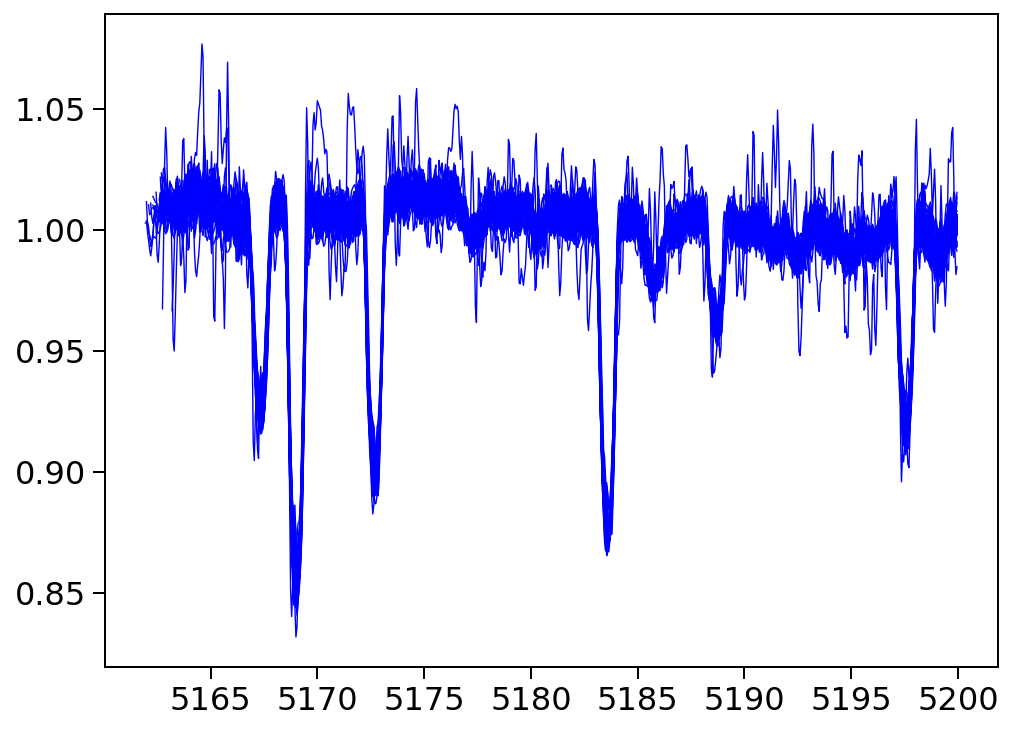

In [13]:
template_wav = np.arange(3000, 5200, 0.05)# - 4923.19189685
# orders = [6,7,8,9,10,11,12,13,14,15,16,17,18, 19,20,21,22]
orders = [22]
all_wavs = []
for p in outofeclipse_spectra[1:]:
    m = 0
    wavs, fluxes = [], []
    for i, order in enumerate(orders):
        wav, flux, hdr = get_spectra(p,order, return_header=True)
        mask = wav > m
        wav, flux = wav[mask], flux[mask]
    #     s_interp = spectres.spectres(template_wav, wav, flux)
        smooth_flux = smooth_spectrum(wav, flux, factor=0.05)
        flat_flux = flatten_spectrum(wav, smooth_flux, s=10)
        flat_flux /= np.median(flat_flux)
#         plt.plot(wav, flat_flux, c='red')
        m = wav[-1]

        wavs.extend(wav- wav_shifts[p])
        fluxes.extend(flat_flux)

    s_interp = spectres.spectres(template_wav, np.array(wavs), np.array(fluxes));
#     _, s_interp = interpolate_spectrum(wavs, fluxes, int_wav=template_wav)
    plt.plot(template_wav, s_interp, c='blue', lw=0.7)
    all_wavs.append(s_interp)

template_flux = np.median(all_wavs, axis=0)

In [20]:
primary_flux

nan

In [33]:
all_wavs = []
for p in primary_spectra[3:-1]:
    m = 0
    wavs, fluxes = [], []
    for i, order in enumerate(orders):
        wav, flux, hdr = get_spectra(p,order, return_header=True)
        mask = wav > m
        wav, flux = wav[mask], flux[mask]
    #     s_interp = spectres.spectres(template_wav, wav, flux)
        smooth_flux = smooth_spectrum(wav, flux, factor=0.05)
        flat_flux = flatten_spectrum(wav, smooth_flux, s=10)
        flat_flux /= np.median(flat_flux)
#         plt.plot(wav, flat_flux, c='red')
        m = wav[-1]

        wavs.extend(wav- wav_shifts[p])
        fluxes.extend(flat_flux)

    s_interp = spectres.spectres(template_wav, np.array(wavs), np.array(fluxes));
    plt.plot(template_wav, s_interp, c='blue', lw=0.7)
    all_wavs.append(s_interp)

primary_flux = np.nanmedian(all_wavs, axis=0)
# plt.plot(template_wav, primary_flux)

In [36]:
s_interp

array([       nan,        nan,        nan, ..., 0.99146782, 0.98146067,
       0.98463668])

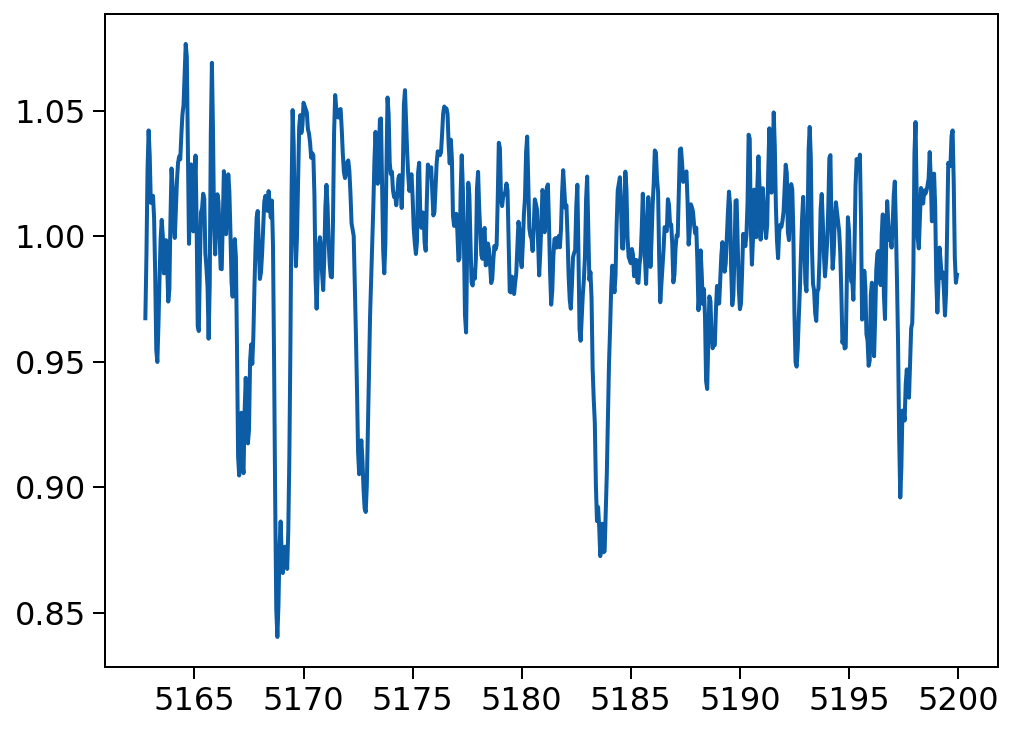

In [37]:
plt.plot(template_wav, s_interp)


Spectres: new_wavs contains values outside the range in spec_wavs. New_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (nan by default).



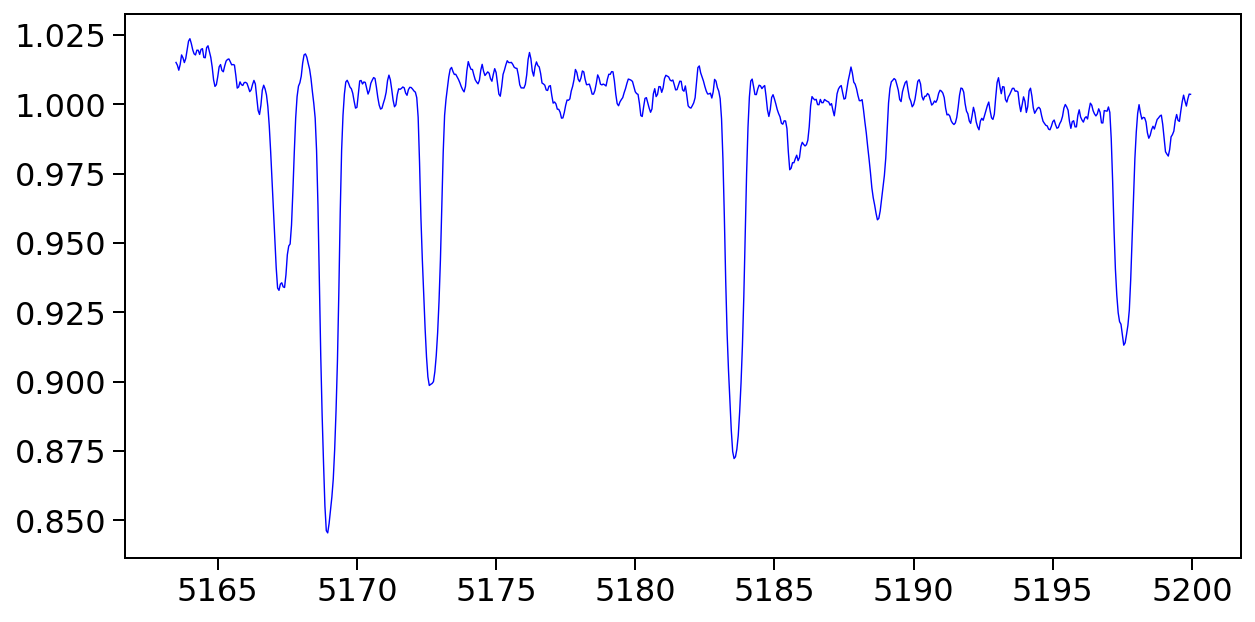

In [38]:

plt.figure(figsize=[10,5])
all_wavs = []
for p in secondary_spectra:
    m = 0
    wavs, fluxes = [], []
    for i, order in enumerate(orders):
        wav, flux, hdr = get_spectra(p,order, return_header=True)
        mask = wav > m
        wav, flux = wav[mask], flux[mask]
    #     s_interp = spectres.spectres(template_wav, wav, flux)
        smooth_flux = smooth_spectrum(wav, flux, factor=0.05)
        flat_flux = flatten_spectrum(wav, smooth_flux, s=10)
        flat_flux /= np.median(flat_flux)
#         plt.plot(wav, flat_flux, c='red')
        m = wav[-1]

        wavs.extend(wav- wav_shifts[p])
        fluxes.extend(flat_flux)

    s_interp = spectres.spectres(template_wav, np.array(wavs), np.array(fluxes));
#     _, s_interp = interpolate_spectrum(wavs, fluxes, int_wav=template_wav)
    plt.plot(template_wav, s_interp, c='blue', lw=0.7)
    all_wavs.append(s_interp)

secondary_flux = np.median(all_wavs, axis=0)

In [18]:
primary_shift_p = primary_flux
primary_shift_s = secondary_flux

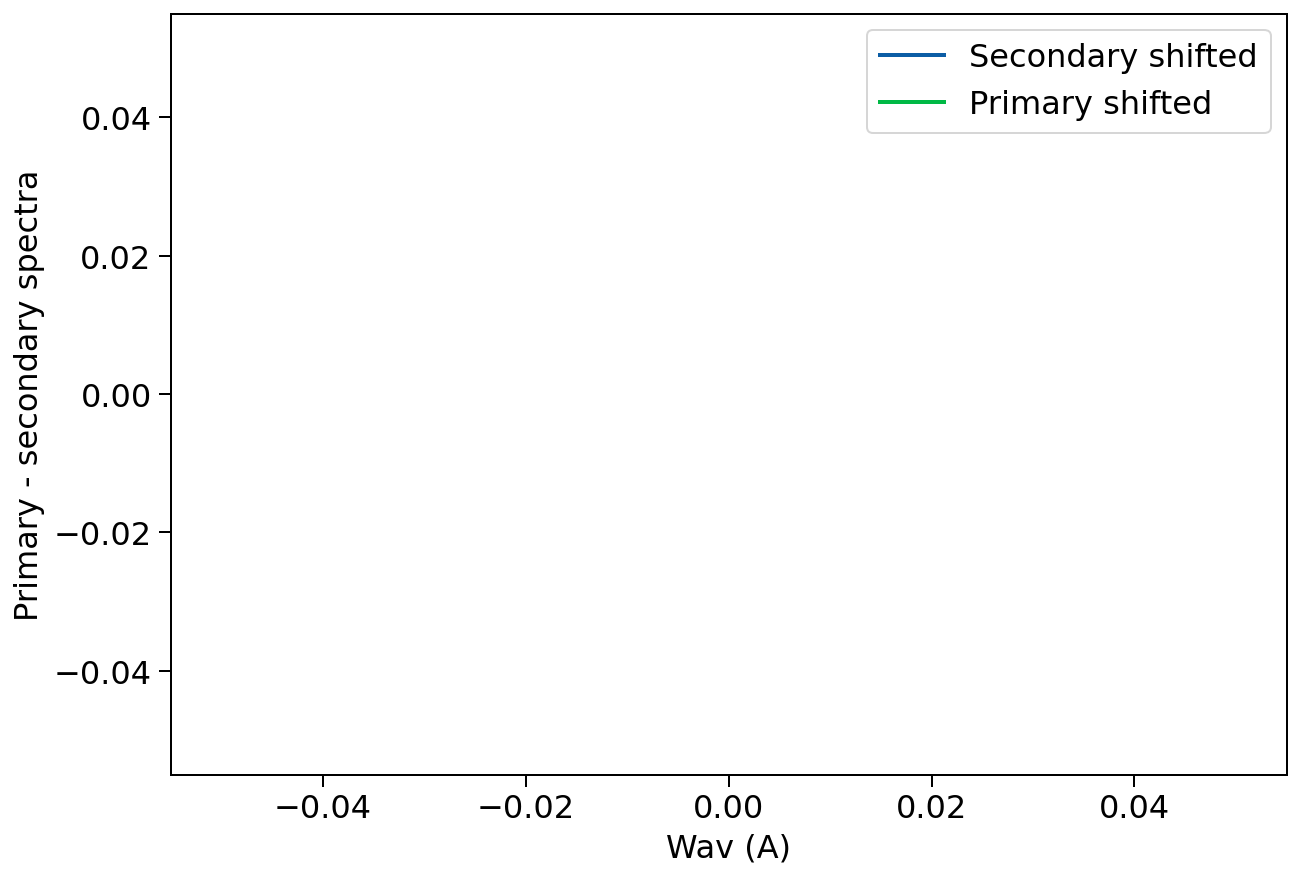

In [19]:
plt.figure(figsize=[10,7])

plt.plot(template_wav, primary_flux - secondary_flux, label='Secondary shifted')
plt.plot(template_wav, primary_shift_p - primary_shift_s, label='Primary shifted')

# plt.xlim(5000,5060)
plt.xlabel('Wav (A)')
plt.ylabel('Primary - secondary spectra')
plt.legend()
# plt.savefig('hmm.png', dpi=300, bbox_inches='tight')

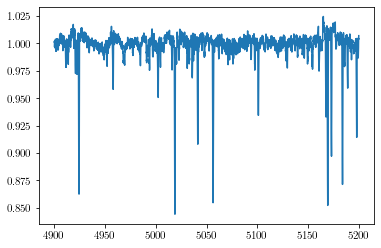

In [137]:
plt.plot(template_wav, primary_flux)

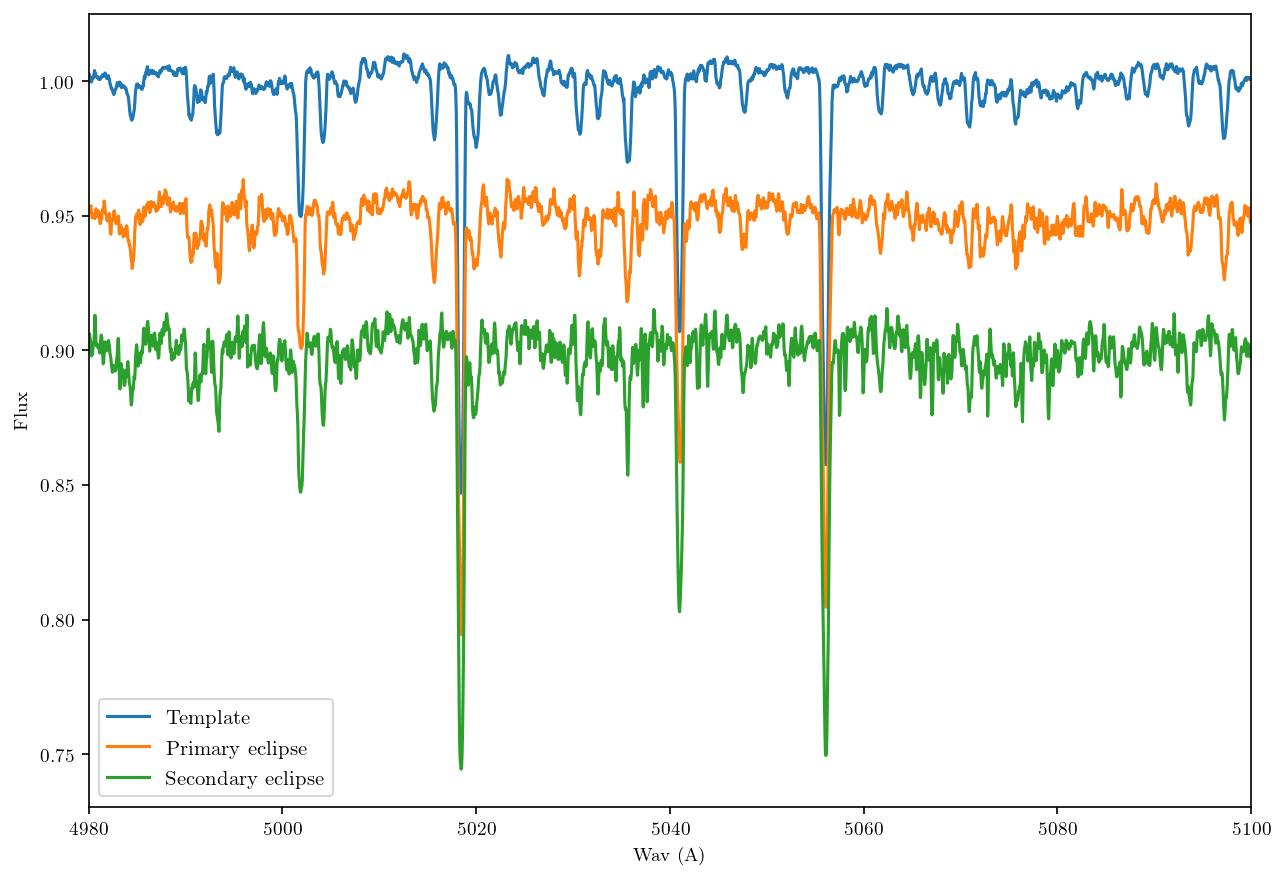

In [50]:
plt.figure(figsize=[10,7])

plt.plot(template_wav, template_flux, label='Template')
plt.plot(template_wav, primary_flux-0.05, label='Primary eclipse')
plt.plot(template_wav, secondary_flux-0.1, label='Secondary eclipse')
plt.xlim(4980,5100)
plt.ylim(None, 1.025)

plt.xlabel('Wav (A)')
plt.ylabel('Flux')
plt.legend()
plt.savefig('gorgeous.png', dpi=300, bbox_inches='tight')

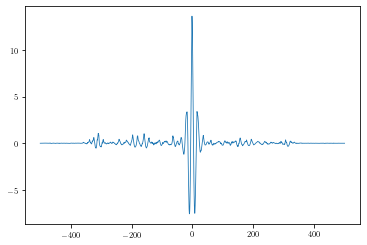

In [88]:
m = np.isnan(template_flux) & np.isnan(primary_flux)
acor1 = np.correlate(template_flux[~m] - 1., primary_flux[~m] - 1., mode='full')

df = template_wav[1] - template_wav[0]
lags = df*np.arange(-len(acor1)//2, len(acor1)//2)
plt.plot(lags, acor1, linewidth=0.8);

In [40]:
order = 16
primary = []
for p in primary_spectra[3:-1]:
    wav, flux, hdr = get_spectra(p,order, return_header=True)
    interp_wav, interp_flux = interpolate_spectrum(wav, flux)
    interp_wav -= wav_shifts[p]
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.05)
    flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
    
    plt.plot(interp_wav, flat_flux, alpha=0.3, c='blue')
    
    primary.append(flat_flux)
# primary = np.array(primary)
# primary = np.median(primary, axis=0)

# wav_primary = interp_wav
# plt.plot(wav_primary, primary, c='black')

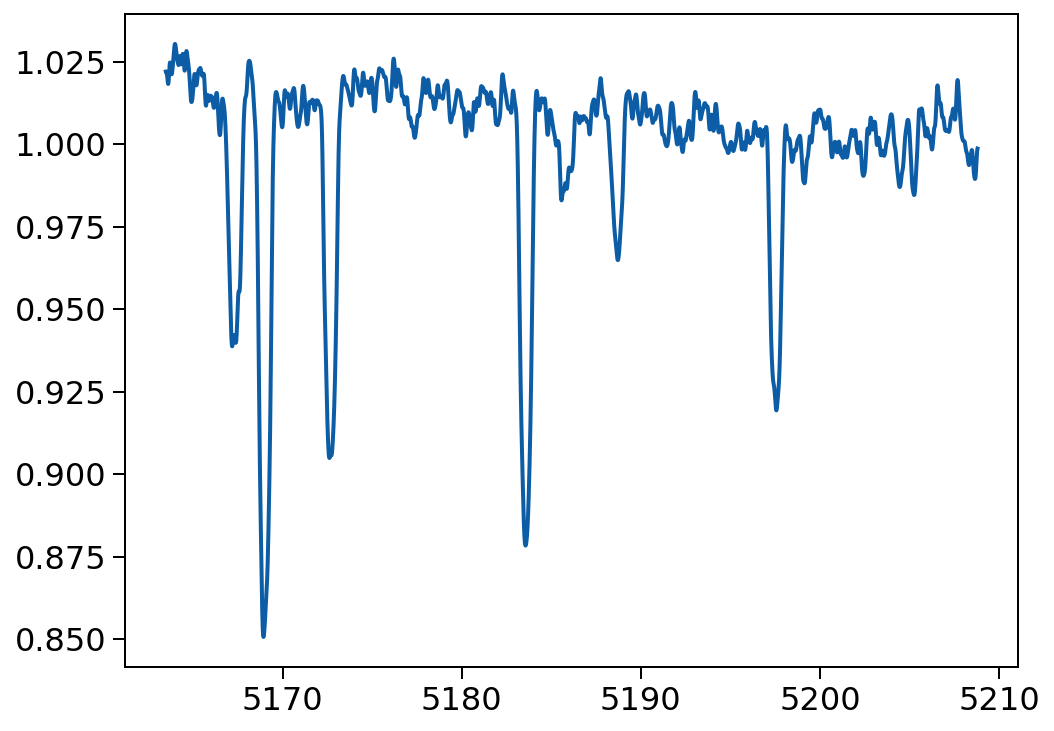

In [42]:
order = 22
secondary = []
for p in secondary_spectra:
    wav, flux, hdr = get_spectra(p,order, return_header=True)
    interp_wav, interp_flux = interpolate_spectrum(wav, flux)
    interp_wav -= wav_shifts[p]
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.05)
    flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
    
    plt.plot(interp_wav, flat_flux)
    secondary.append(flat_flux)
secondary = np.median(np.array(secondary), axis=0)
wav_secondary = interp_wav

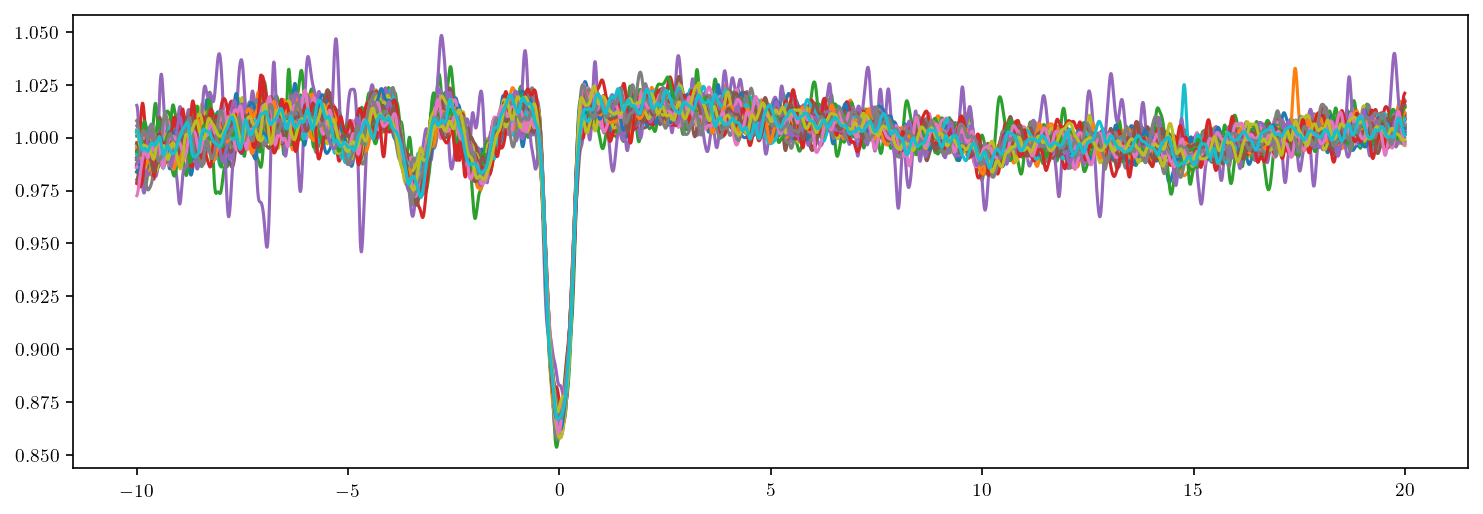

In [197]:
order = 16

p = 0
wav, flux, hdr = get_spectra(p,order, return_header=True)
interp_wav, interp_flux = interpolate_spectrum(wav, flux)
# interp_wav -= wav_shifts[p]
smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.05)
flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)

template_wav = interp_wav

for p in outofeclipse_spectra[1:]:
    wav, flux, hdr = get_spectra(p,order, return_header=True)
    interp_wav, interp_flux = interpolate_spectrum(wav, flux)
    interp_wav -= wav_shifts[p]
    m = (interp_wav < 20) & (interp_wav > -10)
    interp_wav = interp_wav[m]
    interp_flux = interp_flux[m]
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.05)
    flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
    plt.plot(interp_wav, flat_flux)

In [227]:
template_wav = np.arange(-10, 20, 0.0025)

In [39]:
order = 16

# p = 0
# wav, flux, hdr = get_spectra(p,order, return_header=True)
# interp_wav, interp_flux = interpolate_spectrum(wav, flux)
# interp_wav -= wav_shifts[p]
# m = (interp_wav < 20) & (interp_wav > -10)
# smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.05)
# flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
# template_wav = interp_wav[m]

template_wav = np.arange(-10, 20, 0.0025)

outofeclipse = []

for p in outofeclipse_spectra[:]:
    wav, flux, hdr = get_spectra(p,order, return_header=True)
    wav -= wav_shifts[p]
    interp_wav, interp_flux = interpolate_spectrum(wav, flux, int_wav=template_wav)
#     m = (interp_wav < 20) & (interp_wav > -10)
#     interp_wav = interp_wav[m]
#     interp_flux = interp_flux[m]
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.025)
    flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
    plt.plot(interp_wav, flat_flux, c='blue', lw=0.2, alpha=0.2)
    outofeclipse.append(flat_flux)

outofeclipse = np.median(outofeclipse, axis=0)
plt.plot(interp_wav, outofeclipse, c='black')

ValueError: A value in x_new is below the interpolation range.

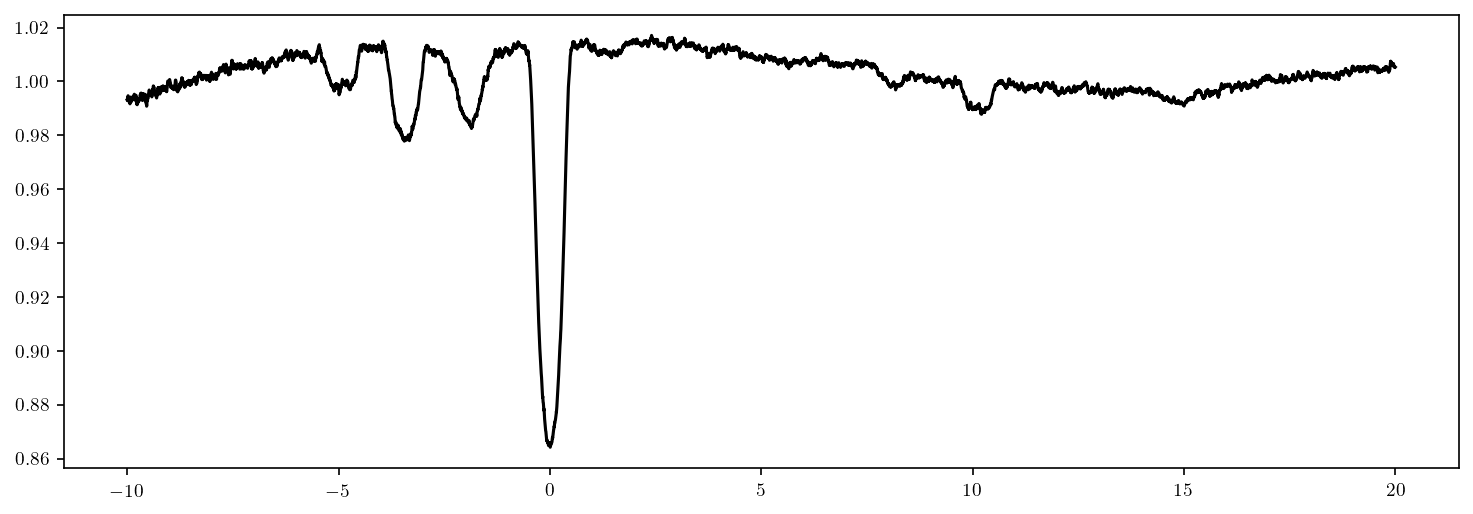

In [234]:
plt.plot(interp_wav, outofeclipse, c='black')

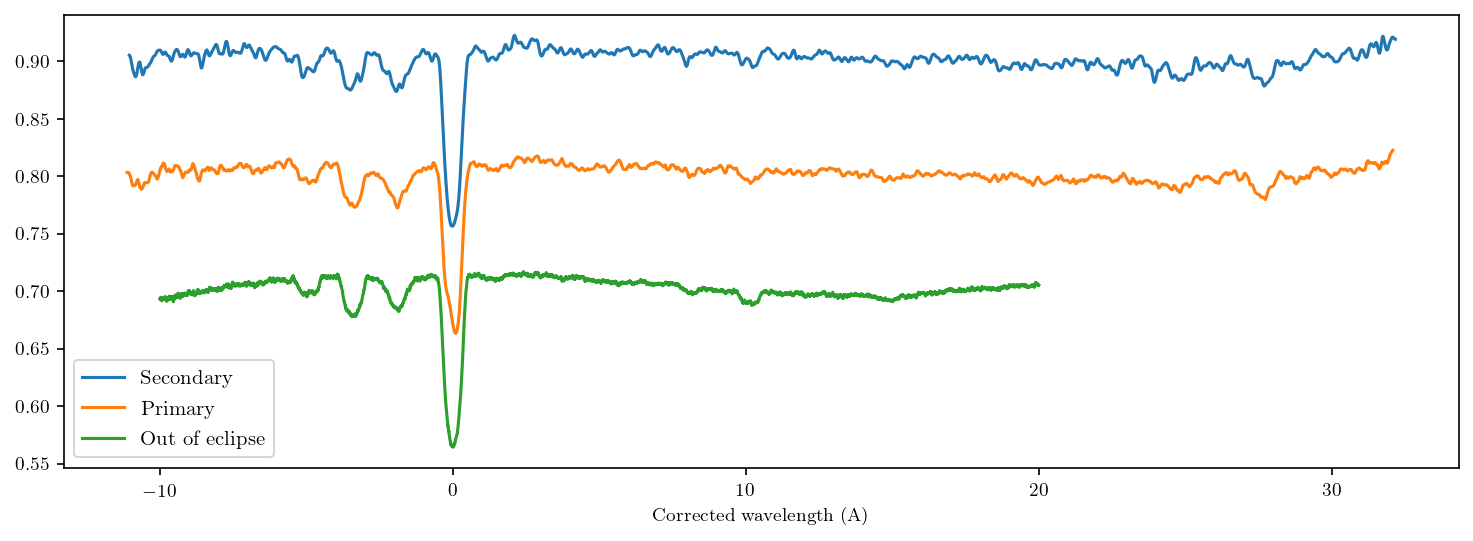

In [231]:
plt.plot(wav_secondary, secondary - 0.1, label='Secondary')
plt.plot(wav_primary, primary - 0.2, label='Primary')
plt.plot(interp_wav, outofeclipse - 0.3, label='Out of eclipse')
plt.legend()

plt.xlabel('Corrected wavelength (A)')

plt.savefig('hmm.png', dpi=300, bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (18015,) and (15262,)

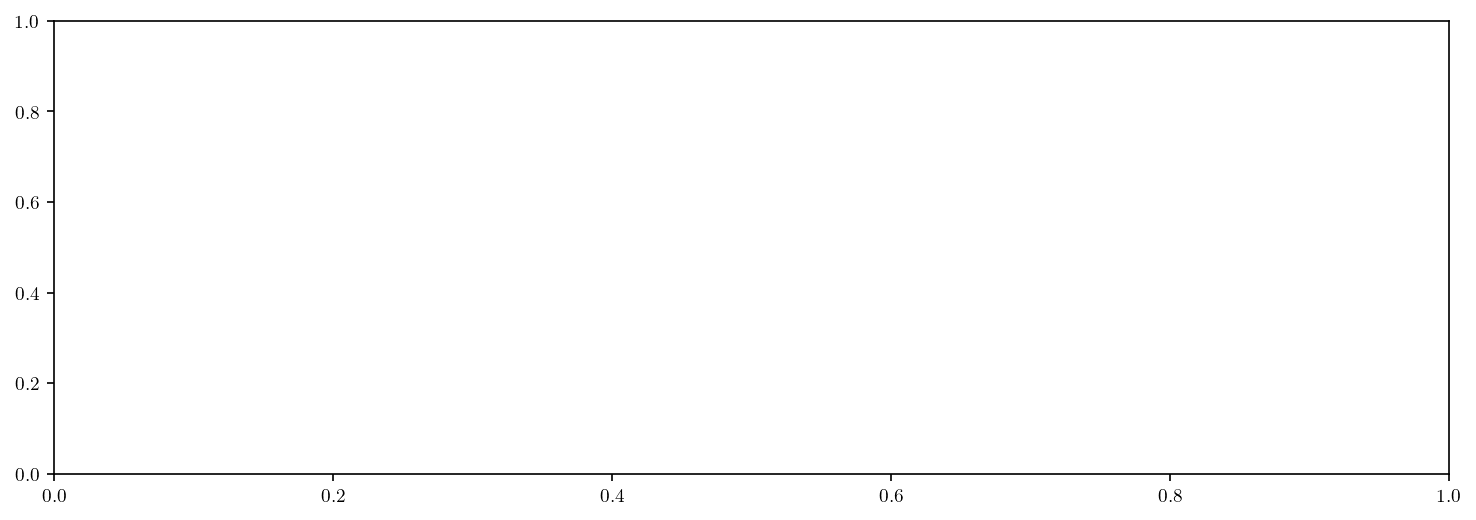

In [222]:
acor1 = np.correlate(secondary - 1., flat_flux - 1., mode='full')
acor2 = np.correlate(secondary - 1., primary - 1., mode='full')
acor3 = np.correlate(primary - 1., flat_flux - 1., mode='full')

df = interp_wav[1] - interp_wav[0]
lags = df*np.arange(-len(acor)//2, len(acor)//2)
plt.plot(lags, acor1-0.3, linewidth=0.8);
plt.plot(lags, acor2-0.6, linewidth=0.8);
plt.plot(lags, acor3-0.9, linewidth=0.8);